# Entrenamiento y evaluación de modelos

En este notebook estaremos realizando el entrenamiento y evaluación de varios modelos que nos pueden resolver nuestro problema. Entendiendo la necesidad, haremos uso de modelos de clasificación binaria, desde DecissionTreeClassifier hasta modelos básicos de redes neuronales.

### ¿Que buscamos?
* Un modelo que generalice bien.
* El modelo que mejor f1-score nos de, sin perder mucho acuraccy ni caer en un recall muy alto y una precision muy baja. De esa manera tendremos un modelo interesante y fiable, ya que aunque buscamos tambien que nos generé falsos positivos, los cuales serán los pacientes que creemos tienen riesgo de sufrir un accidente cerebrovascular, queremos que al menos un porcentaje de ellos sean casos reales.
* El modelo menos costoso en cuanto a tiempo y recursos. De nada nos sirve un modelo técnicamente más complejo pero que mejore apenas poco los resultados.

Sin más dilación, empecemos:

# Librerias

In [2]:
import pandas as pd
import numpy as np 
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, r2_score, precision_score, precision_recall_curve, confusion_matrix, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

In [3]:
df_train = pd.read_csv('../data/train/train.csv')
df_test = pd.read_csv('../data/test/test.csv')

<Axes: >

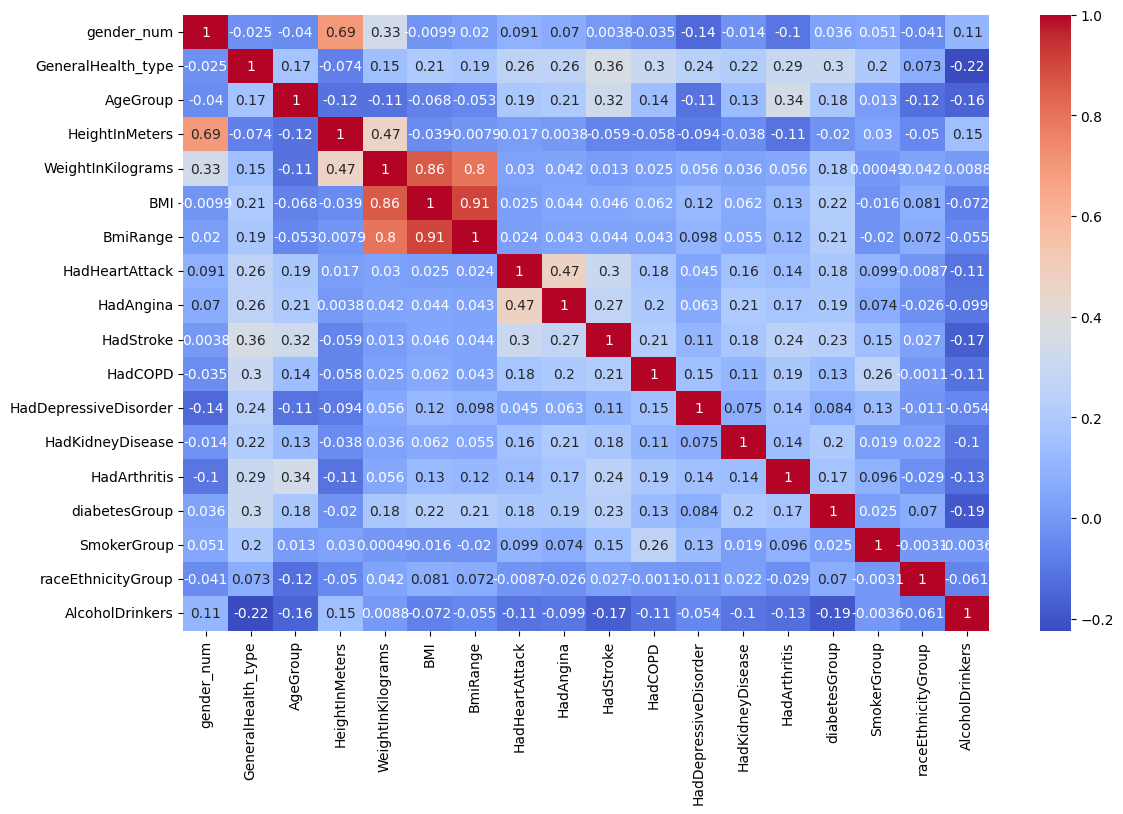

In [4]:
plt.figure(figsize=(13,8))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap="coolwarm")

In [5]:
df_train['HadStroke'].value_counts(normalize=True)

HadStroke
0    0.614091
1    0.385909
Name: proportion, dtype: float64

# Funciones 

In [6]:
def show_metrics(model,x_test, y_test):
    if isinstance(model, GridSearchCV) or isinstance(model, RandomizedSearchCV) :
        print('Best estimator: ',model.best_estimator_)
        print('Best params: ',model.best_params_)
        print('Best score: ',model.best_score_)
        
    y_pred = model.predict(x_test)
    print(type(model).__name__)
    print('accuracy_score', accuracy_score(y_test,y_pred))
    print('precision_score', precision_score(y_test,y_pred))
    print('recall_score', recall_score(y_test,y_pred))
    print('f1_score', f1_score(y_test,y_pred))
    print('confusion matrix \n', confusion_matrix(y_test,y_pred))

In [7]:
def save_dict_metrics(model,x_test, y_test):
    y_pred = model.predict(x_test)
    metrics_dict = {
        "model": type(model).__name__,
        "accuracy": accuracy_score(y_test,y_pred),
        "precision": precision_score(y_test,y_pred),
        "recall": recall_score(y_test,y_pred),
        "f1": f1_score(y_test, y_pred),
        "conf_matrix": confusion_matrix(y_test,y_pred)
    }
    if isinstance(model, GridSearchCV) or isinstance(model, RandomizedSearchCV):
            metrics_dict['best_estimator'] = model.best_estimator_
            metrics_dict['best_params'] = model.best_params_
            metrics_dict['best_score'] = model.best_score_   
    
    return metrics_dict

### Train Test Split

In [8]:
X_train = df_train[['AgeGroup', 'HadHeartAttack', 'diabetesGroup','SmokerGroup', 'AlcoholDrinkers', 'HadArthritis','HadKidneyDisease', 'HadDepressiveDisorder']]
y_train = df_train['HadStroke']

X_test = df_test[['AgeGroup', 'HadHeartAttack', 'diabetesGroup','SmokerGroup', 'AlcoholDrinkers', 'HadArthritis','HadKidneyDisease', 'HadDepressiveDisorder']]
y_test = df_test['HadStroke']

# Modelo 1: DecisionTreeClassifier

Utiliza un árbol de decisión para clasificar los datos. Este modelo es sencillo de interpretar, ya que genera reglas explícitas para la clasificación.
* Al ser interpretable, puede ser utilizado en contextos donde se requiere justificar cada decisión con reglas claras (por ejemplo, para consultas médicas).

In [9]:
dct_model = DecisionTreeClassifier(max_depth=6, criterion='gini')
dct_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=6)

In [10]:
show_metrics(dct_model, X_test, y_test)

DecisionTreeClassifier
accuracy_score 0.7025512176265946
precision_score 0.6083916083916084
recall_score 0.582389289392379
f1_score 0.5951065509076559
confusion matrix 
 [[2504  728]
 [ 811 1131]]


### Bagging con DecissionTree

In [11]:
from sklearn.ensemble import BaggingClassifier

estimator = DecisionTreeClassifier(max_depth=6, random_state=42)
bag_clf = BaggingClassifier(
    estimator = estimator,
    n_estimators=300, # Cantidad de modelos
    max_samples=300, # Muestras utilizadas en boostrapping
    bootstrap=True, # Usamos boostrapping
    # max_features = 3 # Features que utiliza en el boostrapping. Cuanto más bajo, mejor generalizará y menos overfitting
    random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                   random_state=42),
                  max_samples=300, n_estimators=300, random_state=42)

In [12]:
show_metrics(bag_clf, X_test, y_test)

BaggingClassifier
accuracy_score 0.714340935446463
precision_score 0.6384248210023866
recall_score 0.5509783728115345
f1_score 0.5914870093974571
confusion matrix 
 [[2626  606]
 [ 872 1070]]


# Modelo 2: LogisticRegression

Un modelo de Regresión Logística, conocido por su simplicidad y buena capacidad para problemas lineales.
* Este modelo tiende a ofrecer un balance entre precisión y recall. En términos de negocio, sería útil si se busca un modelo interpretable y rápido de implementar.

In [13]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [14]:
show_metrics(lr_model, X_test, y_test)

LogisticRegression
accuracy_score 0.7054503285659065
precision_score 0.5936379928315412
recall_score 0.6822863027806385
f1_score 0.6348826066123623
confusion matrix 
 [[2325  907]
 [ 617 1325]]


# Modelo 3: GradientBoostingClassifier

Algoritmo que entrena modelos en forma secuencial, mejorando iterativamente los errores del modelo anterior.
* Este modelo suele ofrecer buen rendimiento en datos tabulares, maximizando tanto precisión como recall, pero puede ser más costoso en términos computacionales.

In [15]:
gbc_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=6, random_state=42)
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=6, random_state=42)

In [16]:
show_metrics(gbc_model, X_test, y_test)

GradientBoostingClassifier
accuracy_score 0.7044839582528025
precision_score 0.6119241192411924
recall_score 0.5813594232749743
f1_score 0.5962503300765778
confusion matrix 
 [[2516  716]
 [ 813 1129]]


# Modelo 4: RandomForestClassifier

Random Forest es un algoritmo de aprendizaje supervisado que utiliza un conjunto de árboles de decisión para realizar tareas de clasificación o regresión. 

### Con GridSearchCV

El uso de GridSearchCV nos permite explorar automáticamente varias combinaciones de hiperparámetros, seleccionando la mejor combinación basada en una métrica específica (e.g., recall, precisión, exactitud). Esto ayuda a optimizar el modelo para el conjunto de datos.

Ventajas:

* Encuentra automáticamente la combinación óptima de parámetros.
* Permite ajustar el modelo para maximizar una métrica específica.
* Reduce el riesgo de sobreajuste al realizar validación cruzada.

Desventajas:

* Consume más tiempo computacional.
* Puede ser innecesario para problemas simples o datos pequeños.


In [17]:
rf_clf = RandomForestClassifier(random_state=42)

params = {
   "max_depth": [6,10],
   "n_estimators": [50,100,150,200],
   "min_samples_split": [2,4],
   "criterion": ['gini', 'entropy'],
   "class_weight": ['balanced']
}

rf_gs = RandomizedSearchCV(estimator=rf_clf, param_distributions=params, cv=100, scoring='f1', n_jobs=-1, random_state=42)
rf_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=100, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [6, 10],
                                        'min_samples_split': [2, 4],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42, scoring='f1')

In [18]:
show_metrics(rf_gs, X_test, y_test)

Best estimator:  RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=50,
                       random_state=42)
Best params:  {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 6, 'criterion': 'gini', 'class_weight': 'balanced'}
Best score:  0.655952718118153
RandomizedSearchCV
accuracy_score 0.6855431001159644
precision_score 0.5617889368379757
recall_score 0.737384140061792
f1_score 0.6377198842128702
confusion matrix 
 [[2115 1117]
 [ 510 1432]]


### Sin RandomizedSearchCV

Ventajas:

* Selecciona aleatoriamente un subconjunto de combinaciones, lo que reduce significativamente el tiempo de búsqueda.
* Admite distribuciones continuas o discretas para explorar más parámetros sin probar cada combinación exacta.

Desventajas:

* Solo explora una fracción del espacio de búsqueda, por lo que puede omitir la mejor configuración.
* Los resultados dependen del número de iteraciones (n_iter) y pueden variar con diferentes ejecuciones a menos que se fije una semilla (random_state).

In [21]:
rf_model = RandomForestClassifier(n_estimators= 200,min_samples_split=4,max_depth=6,criterion="gini",class_weight="balanced", random_state=42)
rf_model.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=4, n_estimators=200, random_state=42)

In [22]:
show_metrics(rf_model, X_test, y_test)

RandomForestClassifier
accuracy_score 0.6884422110552764
precision_score 0.563953488372093
recall_score 0.7492276004119465
f1_score 0.6435205661211854
confusion matrix 
 [[2107 1125]
 [ 487 1455]]


# Modelo 5: XGBoost

Este modelo utiliza XGBoostClassifier, un algoritmo de aprendizaje supervisado basado en Gradient Boosting, construyendo árboles de decisión de forma secuencial dejando que cada arbol nuevo corrija los errores de los anteriores, minimizando la función de perdida usando gradientes. 

Hasta los momentos este es el modelo que mejor recall nos esta dando, sin embargo hay que recordar que es un modelo que computacionalmente es más costoso.

In [107]:
xgb_model = xgb.XGBClassifier(random_state=42)
params = {
    "max_depth": [6,8,10],
    "n_estimators": [200,300],
    "min_child_weight": [1,2,3],
    "gamma": [0, 0.1, 0.5, 1],
    "learning_rate": [0.01, 0.05, 0.1],
    'scale_pos_weight': [1, 1.5, 3]
}

xgb_gs = RandomizedSearchCV(estimator=xgb_model, param_distributions=params, cv=100, scoring='f1', n_jobs=-1, random_state=42)
xgb_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=100,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_ra...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'gamma': [0, 0.1, 0.5, 1],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [6, 8, 10],
                                        'min_child_weight': [1, 2, 3],
                                        'n_estimators': [200, 300],
                                        'scale_pos_weight': [1, 1.5, 3]},
                   random_state=42, scoring='f1')

In [108]:
show_metrics(xgb_gs, X_test, y_test)

Best estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
Best params:  {'scale_pos_weight': 3, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 1}
Best score:  0.6578809427048367
accuracy_score 0.6298801700811751
precision_score 0.5039073806078148
r

Con este gridSearch hemos conseguido los mejores parámetros para el xgboost, consiguiente los siguientes resultados:

In [109]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=3, n_estimators=200, min_child_weight=3, max_depth=8, learning_rate=0.01, gamma=0.1, random_state= 42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [110]:
show_metrics(xgb_model, X_test, y_test)

accuracy_score 0.5912253575570159
precision_score 0.4771103466525536
recall_score 0.9284243048403708
f1_score 0.6303093864708967
confusion matrix 
 [[1256 1976]
 [ 139 1803]]


Este modelo nos da muy buenos resultados, con un recall de 92% diciendonos que 9 de cada 10 pacientes tienen riesgo de sufrir un acv, aunque de cada 10 solo 5 puedan ser reales. vamos a intentar ajustar estos parámetros al máximo, de manera de conseguir una relación precision-recall perfecta (f1_score).

In [111]:
y_prob = xgb_model.predict_proba(X_test)[:, 1]
precision_list = []
recall_list = []
cust_thresh_list = []
f1_score_list = []
for i in np.arange(0.3,0.9,0.01):
    custom_threshold = i
    y_pred_custom = (y_prob >= custom_threshold).astype(int)
    
    precision_list.append(np.round(precision_score(y_test,y_pred_custom), 4))
    recall_list.append(np.round(recall_score(y_test,y_pred_custom), 4))
    f1_score_list.append(np.round(f1_score(y_test,y_pred_custom), 4))
    cust_thresh_list.append(i) 

best_dict = {"precision": precision_list,
             "recall": recall_list,
             "f1_score": f1_score_list,
             "thresh": cust_thresh_list
             }

df_thresh = pd.DataFrame(best_dict)

In [112]:
df_thresh['f1_score'].max()

np.float64(0.6505)

In [113]:
show_metrics(xgb_model, X_test, y_test)

accuracy_score 0.5912253575570159
precision_score 0.4771103466525536
recall_score 0.9284243048403708
f1_score 0.6303093864708967
confusion matrix 
 [[1256 1976]
 [ 139 1803]]


No hemos conseguido ajustar de manera de mejorar las métricas.

# Modelo 6: Pipeline

Prueba de un pipeline con los dos mejores modelos hasta ahora, escalando datos. No vemos ninguna mejora sustancial frente a otros modelos.

In [114]:
pipe = Pipeline(steps=[("scaler", StandardScaler()),
    ('classifier', svm.SVC())
])
random_forest_params = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [RandomForestClassifier(n_estimators= 200,min_samples_split=4,max_depth=6,criterion="gini",class_weight="balanced")],
}

xgb_param = {
    'classifier': [xgb.XGBClassifier(scale_pos_weight=3, n_estimators=200, min_child_weight=3, max_depth=8, learning_rate=0.01, gamma=0.1, random_state= 42)],
}

search_space = [
    random_forest_params,
    xgb_param
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  scoring='f1',
                  cv = 5)

clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier': [RandomForestClassifier(class_weight='balanced',
                                                                max_depth=6,
                                                                min_samples_split=4,
                                                                n_estimators=200)],
                          'scaler': [StandardScaler(), MinMaxScaler(), None]},
                         {'classifier': [XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsampl...
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       interaction_constraints=None,
                                                       learning_rate=0.01,
                                                       max_bin=None,
                                                       max_cat_threshold=None,
                                                       max_cat_to_onehot=None,
                                                       max_delta_step=None,
                                                       max_depth=8,
                                                       max_leaves=None,
                                                       min_child_weight=3,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       multi_strategy=None,
                                                       n_estimators=200,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=42, ...)]}],
             scoring='f1')

In [115]:
show_metrics(clf, X_test, y_test)

Best estimator:  Pipeline(steps=[('scaler', None),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        min_samples_split=4,
                                        n_estimators=200))])
Best params:  {'classifier': RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=4, n_estimators=200), 'scaler': None}
Best score:  0.6579637918882997
accuracy_score 0.6890220332431388
precision_score 0.5647104547221142
recall_score 0.7481977342945417
f1_score 0.6436323366555925
confusion matrix 
 [[2112 1120]
 [ 489 1453]]


# Modelo 7: Pipeline con KMeans

Unión de no supervisado KMeans y los dos mejores modelos hasta ahora. Se han hecho GridSearchCV con los dos para conseguir los mejores parametros de K en función de mejorar el recall

In [116]:
pipeline_kmeans_xgb = Pipeline([
    ("kmeans", KMeans(n_clusters=2, n_init='auto', random_state=42)), # Utiliza solo X_train
    ('xgboost', xgb.XGBClassifier(scale_pos_weight=3, n_estimators=200, min_child_weight=3, max_depth=8, learning_rate=0.01, gamma=0.1, random_state= 42))
])
pipeline_kmeans_xgb.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=2, random_state=42)),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

In [117]:
show_metrics(pipeline_kmeans_xgb, X_test, y_test)

accuracy_score 0.6235021260146888
precision_score 0.4991438356164384
recall_score 0.9006179196704428
f1_score 0.6423062798384135
confusion matrix 
 [[1477 1755]
 [ 193 1749]]


In [118]:
pipeline_kmeans_rf = Pipeline([
    ("kmeans", KMeans(n_clusters=2, n_init='auto', random_state=42)), # Utiliza solo X_train
    ('randomforest', RandomForestClassifier(n_estimators= 200,min_samples_split=4,max_depth=6,criterion="gini",class_weight="balanced"))
])
pipeline_kmeans_rf.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=2, random_state=42)),
                ('randomforest',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        min_samples_split=4,
                                        n_estimators=200))])

In [119]:
show_metrics(pipeline_kmeans_rf, X_test, y_test)

accuracy_score 0.6863161963664476
precision_score 0.5633690901867302
recall_score 0.7301750772399588
f1_score 0.6360170441803095
confusion matrix 
 [[2133 1099]
 [ 524 1418]]


# Modelo 8: Pipeline con PCA

Vamos a probar nuestros dos mejores modelos reduciendo la dimensionalidad y ver si mejora los resultados. Se ha usado GridSearchCV para encontrar el mejor valor de n_components

In [120]:
pipeline_pca_xgb = Pipeline([
    ("pca", PCA(n_components=5,random_state=42)),
    ('xgboost', xgb.XGBClassifier(scale_pos_weight=3, n_estimators=200, min_child_weight=3, max_depth=8, learning_rate=0.01, gamma=0.1, random_state= 42))
])
pipeline_pca_xgb.fit(X_train, y_train)
show_metrics(pipeline_pca_xgb, X_test, y_test)

accuracy_score 0.6153846153846154
precision_score 0.49326599326599324
recall_score 0.9052523171987642
f1_score 0.6385760988013076
confusion matrix 
 [[1426 1806]
 [ 184 1758]]


In [121]:
pipeline_pca_rf = Pipeline([
    ("pca", PCA(n_components=3,random_state=42)), 
    ('randomforest', RandomForestClassifier(n_estimators= 200,min_samples_split=4,max_depth=6,criterion="gini",class_weight="balanced"))
])
pipeline_pca_rf.fit(X_train, y_train)
show_metrics(pipeline_pca_rf, X_test, y_test)

accuracy_score 0.6809045226130653
precision_score 0.5547610086563793
recall_score 0.7590113285272915
f1_score 0.6410089149815177
confusion matrix 
 [[2049 1183]
 [ 468 1474]]


# Modelo 10: Redes neuronales 

Quizás son muy complejas para problemas de este tipo, pero no perdemos mucho probando las de SKLearn, un modelo de red neuronal multicapa (MLPClassifier).

In [122]:
mlp = MLPClassifier(max_iter=500)
mlp.fit(X_train, y_train)

MLPClassifier(max_iter=500)

In [123]:
show_metrics(mlp, X_test, y_test)

accuracy_score 0.7131812910707384
precision_score 0.6243213897937026
recall_score 0.592173017507724
f1_score 0.6078224101479915
confusion matrix 
 [[2540  692]
 [ 792 1150]]


En general, vemos métricas muy pares, con una precisión de 63% y un recall de 61%

# Elección de modelo

Si he de escoger, el modelo de random forest por coste y ratio precision/recall nos viene muy bien. Sin embargo, el logisticRegression tambien esta muy interesante.

Comparación: 

In [124]:
lr_model_metrics = save_dict_metrics(lr_model, X_test, y_test)
rf_model_metrics = save_dict_metrics(rf_model, X_test, y_test)

df_comparativa = pd.DataFrame([lr_model_metrics, rf_model_metrics]).set_index('model')

In [125]:
df_comparativa

,accuracy,precision,recall,f1,conf_matrix
model,,,,,
LogisticRegression,0.705450,0.593638,0.682286,0.634883,"[[2325, 907], [617, 1325]]"
RandomForestClassifier,0.689215,0.564529,0.752317,0.645033,"[[2105, 1127], [481, 1461]]"


* Logistic Regression:
68 de cada 100 pacientes estan en riesgo de sufrir accidentes, mientras que 59 de cada 100 realmente lo estan.
* Random Forest: 
75 de cada 100 pacientes estan en riesgo de sufrir accidentes, mientras que 56 de cada 100 realmente lo estan.

¿Cuál funciona mejor?

Si el objetivo principal es maximizar el recall (detectar la mayor cantidad posible de pacientes en riesgo), el Random Forest es la mejor opción (75.18% frente a 68.22%).
Si se busca un mejor balance entre precisión y recall, el Logistic Regression tiene mayor precisión (59.36% frente a 56.30%), aunque tampoco es muy significativo

En problemas de salud como este, suele ser más crítico maximizar el recall para minimizar el riesgo de no detectar pacientes en peligro. Por ello, usaremos el Random Forest.


# Guardado Modelo

In [126]:
# Guardar el modelo
with open('../models/trained_model_1.pkl', "wb") as archivo_salida:
    pickle.dump(dct_model, archivo_salida)
with open('../models/trained_model_2.pkl', "wb") as archivo_salida:
    pickle.dump(rf_model, archivo_salida)

with open('../models/final_model.pkl', "wb") as archivo_salida:
    pickle.dump(rf_model, archivo_salida)